# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

from pathlib import Path
import os.path

from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Load and Transform Data

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

# Placing data into a Dataframe


In [4]:
dataset = "Spotflock_India/train"
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
image_df

,Filepath,Label
0,Spotflock_India/train/Humayun Tomb/humayuntomb...,Humayun Tomb
1,Spotflock_India/train/Humayun Tomb/humayuntomb...,Humayun Tomb
2,Spotflock_India/train/Humayun Tomb/humayuntomb...,Humayun Tomb
3,Spotflock_India/train/Humayun Tomb/humayuntomb...,Humayun Tomb
4,Spotflock_India/train/Humayun Tomb/humayuntomb...,Humayun Tomb
...,...,...
1002,Spotflock_India/train/Qutub Minar/qutubminar_5...,Qutub Minar
1003,Spotflock_India/train/Qutub Minar/qutubminar_9...,Qutub Minar
1004,Spotflock_India/train/Qutub Minar/qutubminar_8...,Qutub Minar
1005,Spotflock_India/train/Qutub Minar/qutubminar_1...,Qutub Minar


# Visualizing images from the dataset

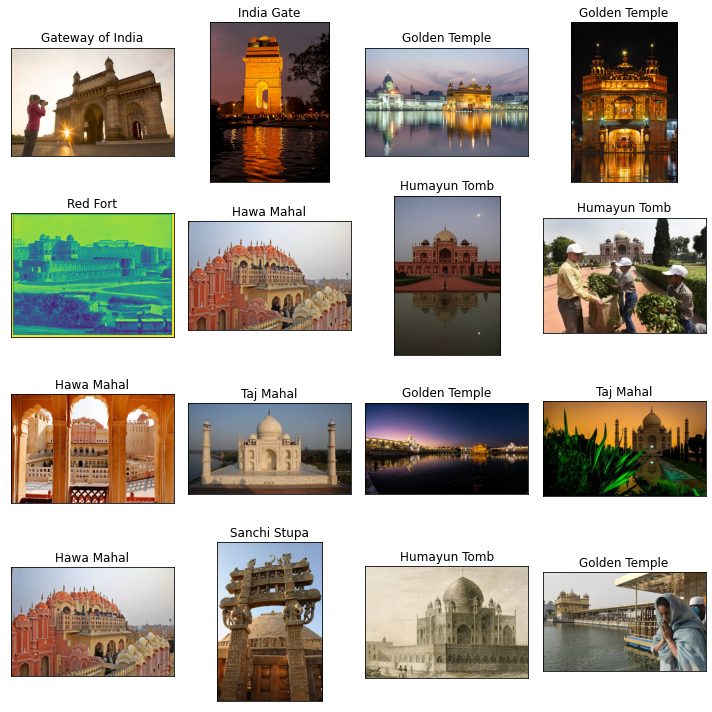

In [6]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Data Preprocessing

In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [8]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 644 validated image filenames belonging to 10 classes.
Found 161 validated image filenames belonging to 10 classes.
Found 202 validated image filenames belonging to 10 classes.


## Resizing and Rescaling

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Training the model

I will be using MobileNetV2 for classification, with earlystopping. I will also be creating model checkpoints. 


**Batch size** : 32

**Epochs** : 100

**Input Shape** : (224, 224, 3)

**Output layer** : 10



In [11]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [12]:
# Create checkpoint callback
checkpoint_path = "indian_place_classifier"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

## Setting up EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 consecutive epochs


In [13]:
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# Training the model

In [14]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/10
21/21 [==============================] - 44s 2s/step - loss: 2.3115 - accuracy: 0.1320 - val_loss: 2.0349 - val_accuracy: 0.4161
Epoch 2/10
21/21 [==============================] - 35s 2s/step - loss: 1.9011 - accuracy: 0.3944 - val_loss: 1.7597 - val_accuracy: 0.5839
Epoch 3/10
21/21 [==============================] - 36s 2s/step - loss: 1.6055 - accuracy: 0.5714 - val_loss: 1.4845 - val_accuracy: 0.6708
Epoch 4/10
21/21 [==============================] - 33s 2s/step - loss: 1.3147 - accuracy: 0.6724 - val_loss: 1.2540 - val_accuracy: 0.7081
Epoch 5/10
21/21 [==============================] - 31s 1s/step - loss: 1.0911 - accuracy: 0.7096 - val_loss: 1.0739 - val_accuracy: 0.7329
Epoch 6/10
21/21 [==============================] - 31s 1s/step - loss: 0.9392 - accuracy: 0.7453 - val_loss: 0.9346 - val_accuracy: 0.7453
Epoch 7/10
21/21 [==============================] - 32s 2s/step - loss: 0.7912 - accuracy: 0.7857 - val_loss: 0.8279 - val_accuracy: 0.7764
Epoch 8/10
21/21 [==

# Model Evaluation


In [15]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.57080
Test Accuracy: 86.63%


# Visualizing loss curves

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('EPOCH')
  plt.ylabel('ERROR')
  plt.legend()
  plt.grid(True)

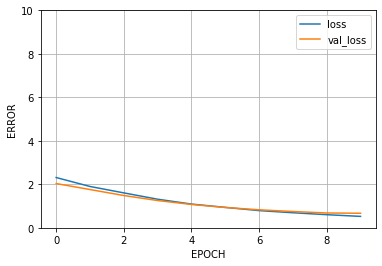

In [17]:
plot_loss(history)

# Making predictions on the Test Data

In [18]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Mapping the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['India Gate', 'Gateway of India', 'Red Fort', 'Red Fort', 'Sanchi Stupa']


In [19]:
train_images.class_indices

{'Gateway of India': 0,
 'Golden Temple': 1,
 'Hawa Mahal': 2,
 'Humayun Tomb': 3,
 'India Gate': 4,
 'Qutub Minar': 5,
 'Red Fort': 6,
 'Sanchi Stupa': 7,
 'Statue of Unity': 8,
 'Taj Mahal': 9}

## Displaying 15 random pictures from the dataset with their labels


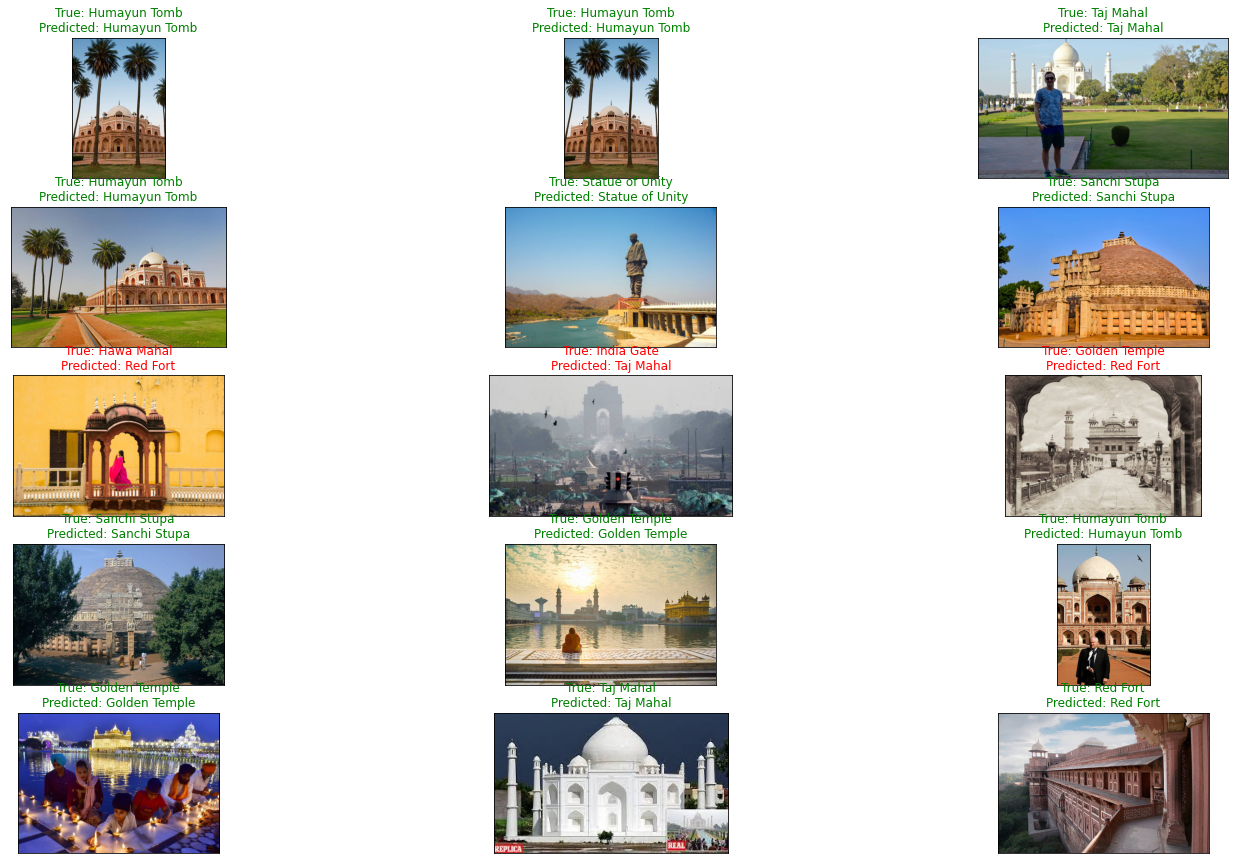

<Figure size 432x288 with 0 Axes>

In [20]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Plotting the Classification Reports and Confusion Matrix

In [21]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                  precision    recall  f1-score   support

Gateway of India       0.83      0.94      0.88        16
   Golden Temple       0.93      0.90      0.92        31
      Hawa Mahal       0.93      0.90      0.92        30
    Humayun Tomb       0.81      0.65      0.72        20
      India Gate       1.00      0.73      0.84        22
     Qutub Minar       1.00      0.57      0.73         7
        Red Fort       0.71      0.83      0.77        18
    Sanchi Stupa       0.90      0.95      0.93        20
 Statue of Unity       0.79      1.00      0.88        19
       Taj Mahal       0.83      1.00      0.90        19

        accuracy                           0.87       202
       macro avg       0.87      0.85      0.85       202
    weighted avg       0.88      0.87      0.86       202



In [22]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Gateway of India,0.833333,0.937500,0.882353,16.000000
Golden Temple,0.933333,0.903226,0.918033,31.000000
Hawa Mahal,0.931034,0.900000,0.915254,30.000000
Humayun Tomb,0.812500,0.650000,0.722222,20.000000
India Gate,1.000000,0.727273,0.842105,22.000000
Qutub Minar,1.000000,0.571429,0.727273,7.000000
Red Fort,0.714286,0.833333,0.769231,18.000000
Sanchi Stupa,0.904762,0.950000,0.926829,20.000000
Statue of Unity,0.791667,1.000000,0.883721,19.000000
Taj Mahal,0.826087,1.000000,0.904762,19.000000


## Save the Model

In [23]:
#model.save('Spotflock.h5')

## Pickle the Model

In [24]:
#import pickle


#Best_model = history
#file = 'Spotflock_India_classifier.pkl'
#fileobj = open(file, 'wb')
#pickle.dump(history, fileobj)
#fileobj.close()